<a href="https://colab.research.google.com/github/mileslilly2/code_for_whatever_you_are/blob/main/REE_Global_Supply_and_EndUse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 01 – Global REE Supply and End‑Use
Downloads USGS MCS 2024 tables, parses end‑use split, and builds a Sankey.

In [ ]:

# 1️⃣  Install once if missing
!pip install pandas requests plotly pdfplumber


In [ ]:

import requests, zipfile, io, pandas as pd, pdfplumber, re, plotly.graph_objects as go, os, pathlib
pathlib.Path('intermediate').mkdir(exist_ok=True)


### 1. Download the `world.zip` production tables

In [ ]:
WORLD_ZIP_URL = (
    "https://www.sciencebase.gov/catalog/file/get/"
    "65a6e45fd34e5af967a46749?name=world.zip"
)
world_zip_path = '/content/intermediate/world.zip'
if not os.path.exists(world_zip_path):
    r = requests.get(WORLD_ZIP_URL, timeout=60)
    open(world_zip_path, 'wb').write(r.content)

In [ ]:
print(r)

<Response [200]>


In [ ]:
print(r.content)

b'PK\x03\x04\x14\x00\x00\x00\x08\x00\x906fX\x8a9\xc2pt\x02\x00\x00\xcd\x08\x00\x002\x00\x00\x00MCS 2024 Data Release Revision File 2024-03-06.txt\xbdU\xdbj\xdb@\x10}7\xf8\x1f\x06?%%1%\xb4\x1f\xa0\xc8&\x11XR\x90\xe4\xd0\xf6%l\xb4ck\xc9^\xd2\xdd\x95\x1d\xe7\xeb;+\xbb`\xb9\x14\xe2\x16d#\x04\xd2\xcc9gf\x8ff\xd2\xb8\x84\x9b\xcf7_`\xc6<\x83\x02%2\x87t\xdf\x08\'\x8c\x86\xccxt0\x1e}\xfa\xc0o<\xaa\x1a\x84\x95\x91\xd2l\x85^C\\>\xc2JH\xca\xdf\xa2E\xb0\xf8*Y\x8d\x1c\x086e\xb6n\xe0\xeb\xd5\x9e\xfa\x1a\xa4p\x9e\xde<\xef\xa06J\x19.\xfc\xee\xa3\x9c\xe3\xd1mT$\xd5|<J4\xa8\xda\x05\xc4\xebgf\x85\x7f\xda\x1a+\xf9\xb4v\x9b+\xa8\x1b\xa6\xd7\xc4\xd0j\xe1\x1d\x08M\xc2Pr\xd0L\x91<o\xe0\xc5\xc3\x85oL\xeb\x98\xe6\xa0\xd0[Q\xd3c\xed.\xc12\xdf\xa0\x05O\x00@A\xc7\xef\xa6{\xf6\xe57\xa2\x87(\x9bA\xb4X\xa6I\x16\x9dHi\xdf\xc4@R\xf2"\xcf\xfa\xe4\xc6\x1a=\x0cy|_\xe4i\xb2L{\xfcuc\x8d\x1a\x88\x7f\x11}/\xfb\xe4\x92\xed\xdc0\xe4\xb3$\xaa\xf2\xf4\xd4\x85\\0o\x86\x11p7/\xd2(;m\xff\x1a\xadbg\tX\xc3\xc5\x8b\x90fm\x99r\x97\x01\xf

In [ ]:
world_zip = zipfile.ZipFile(world_zip_path)

In [ ]:
world_zip


<zipfile.ZipFile filename='/content/intermediate/world.zip' mode='r'>

In [ ]:
world_zip.namelist()[0:5]

['MCS 2024 Data Release Revision File 2024-03-06.txt',
 'mcs2024-abras_meta.xml',
 'mcs2024-abras_world.csv',
 'mcs2024-alumi_meta.xml',
 'mcs2024-alumi_world.csv']

Grab the csv we need


In [ ]:
prod_csv = [f for f in world_zip.namelist() if 'raree_world' in f][0]

In [ ]:
prod_csv

'mcs2024-raree_world.csv'

In [ ]:
prod = pd.read_csv(world_zip.open(prod_csv))

In [ ]:
prod.head()

,Source,Country,Type,Prod_t_est_2022,Prod_t_est_2023,Prod_notes,Reserves_t,Reserves_notes,Unnamed: 8,Unnamed: 9,...,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43
0,MCS2024,United States,"Rare earths, mine production, rare-earth-oxide...",42000.0,43000.0,NaN,1800000.0,"Reserves for Australia, Russia, Thailand, and ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MCS2024,Australia,"Rare earths, mine production, rare-earth-oxide...",18000.0,18000.0,NaN,5700000.0,"For Australia, Joint Ore Reserves Committee-co...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MCS2024,Brazil,"Rare earths, mine production, rare-earth-oxide...",80.0,80.0,NaN,21000000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MCS2024,Burma,"Rare earths, mine production, rare-earth-oxide...",12000.0,38000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MCS2024,Canada,"Rare earths, mine production, rare-earth-oxide...",0.0,0.0,NaN,830000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


subset the data

In [ ]:
import pandas as pd

# Assuming your original DataFrame is named `df`
selected_columns = [
    'Country',
    'Prod_t_est_2022',
    'Prod_t_est_2023',
    'Prod_notes',
    'Reserves_t',
    'Reserves_notes'
]

ree_df = prod[selected_columns].dropna(how='all', subset=['Prod_t_est_2022', 'Prod_t_est_2023', 'Reserves_t'])




In [ ]:
ree_df.head()

,Country,Prod_t_est_2022,Prod_t_est_2023,Prod_notes,Reserves_t,Reserves_notes
0,United States,42000.0,43000.0,NaN,1800000.0,"Reserves for Australia, Russia, Thailand, and ..."
1,Australia,18000.0,18000.0,NaN,5700000.0,"For Australia, Joint Ore Reserves Committee-co..."
2,Brazil,80.0,80.0,NaN,21000000.0,NaN
3,Burma,12000.0,38000.0,NaN,NaN,NaN
4,Canada,0.0,0.0,NaN,830000.0,NaN


Build out our plots comparing production

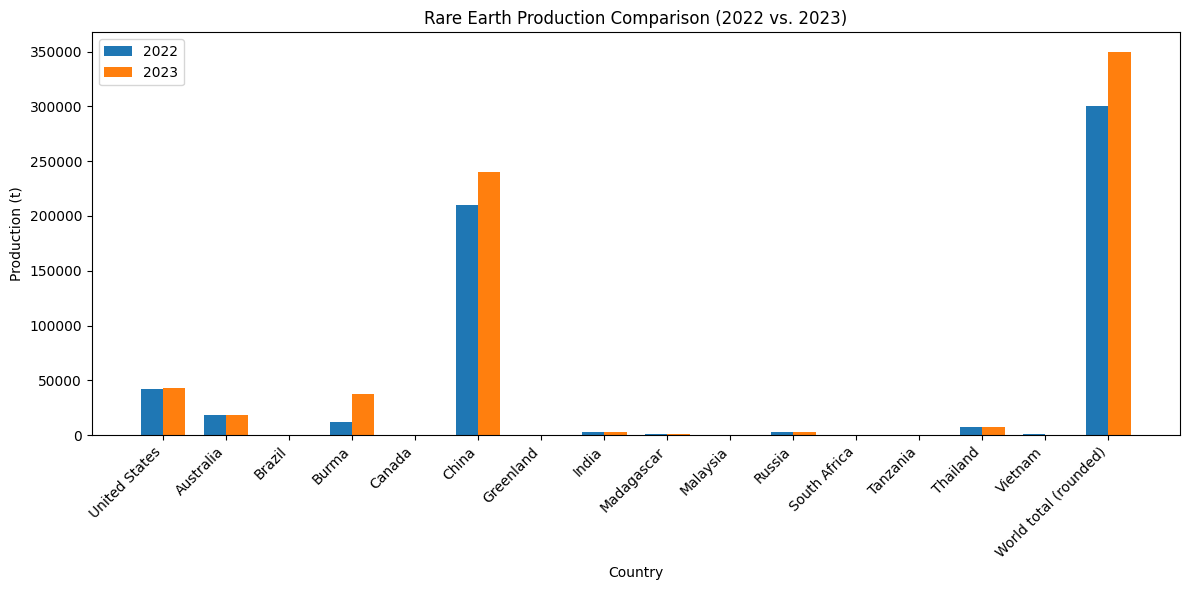

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ree_df['Country']
prod_2022 = ree_df['Prod_t_est_2022']
prod_2023 = ree_df['Prod_t_est_2023']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, prod_2022, width, label='2022')
bars2 = ax.bar(x + width/2, prod_2023, width, label='2023')

ax.set_xlabel('Country')
ax.set_ylabel('Production (t)')
ax.set_title('Rare Earth Production Comparison (2022 vs. 2023)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px

# Drop rows with NaNs in Reserves_t
clean_ree_df = ree_df.dropna(subset=['Reserves_t'])

fig = px.scatter_geo(
    clean_ree_df,
    locations='Country',
    locationmode='country names',
    size='Reserves_t',
    hover_name='Country',
    size_max=40,
    title='Rare Earth Reserves by Country'
)
fig.show()


### 2. Parse end‑use percentages from Rare‑Earths PDF

In [105]:
import os
import requests
import pdfplumber

PDF_URL = "https://pubs.usgs.gov/periodicals/mcs2024/mcs2024-rare-earths.pdf"
pdf_path = 'intermediate/mcs2024-rare-earths.pdf'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(pdf_path), exist_ok=True)

if not os.path.exists(pdf_path):
    with open(pdf_path, 'wb') as f:
        f.write(requests.get(PDF_URL, timeout=60).content)

with pdfplumber.open(pdf_path) as pdf:
    text = pdf.pages[0].extract_text()

print(text[0:1000])


144
RARE EARTHS1
[Data in metric tons, rare-earth-oxide (REO) equivalent, unless otherwise specified]
Domestic Production and Use: Rare earths were mined domestically in 2023. Bastnaesite (or bastnäsite), a rare-
earth fluorocarbonate mineral, was mined as a primary product at a mine in Mountain Pass, CA. Monazite, a
phosphate mineral, was stockpiled as a separated concentrate or included as an accessory mineral in heavy-mineral-
sand concentrates in the southeastern United States. Mixed rare-earth compounds were also produced in the western
United States. The estimated value of rare-earth compounds and metals imported by the United States in 2023 was
$190 million, a 7% decrease from $208 million in 2022. The estimated leading domestic end use of rare earths was
catalysts. Significant amounts of rare earths are imported as permanent magnets embedded in finished goods. Other
end uses were ceramics and glass, metallurgical applications and alloys, and polishing.
Salient Statistics—United

# Domestic Production and Use

In [109]:
import re, pandas as pd
data = {}
# 1) Import value and YoY change
m = re.search(r'\$(\d+)\s*million.*?(\d+)%\s*decrease\s*from\s*\$(\d+)', text, re.I)
if m:
    data['Import_value_2023_mUSD'] = int(m.group(1))
    data['Import_value_2022_mUSD'] = int(m.group(3))
    data['YoY_change_%']           = -int(m.group(2))    # negative since 'decrease'

# 2) Leading end use
m = re.search(r'leading\s+domestic\s+end\s+use\s+of\s+rare\s+earths\s+was\s+([a-z]+)', text, re.I)
if m:
    data['Leading_end_use'] = m.group(1).lower()

# 3) Other end uses (comma-separated at end of sentence)
m = re.search(r'Other\s+end\s+uses\s+were\s+(.+?)\.', text, re.I)

if m:
    others = [u.strip().lower() for u in m.group(1).split(',')]
    data['Other_end_uses'] = others

# 4) Whether mined domestically
data['Mined_domestically_2023'] = bool(re.search(r'mined domestically in 2023', text, re.I))

df_paragraph = pd.DataFrame([data])
df_paragraph


,Import_value_2023_mUSD,Import_value_2022_mUSD,YoY_change_%,Leading_end_use,Other_end_uses,Mined_domestically_2023
0,190,208,-7,catalysts,"[ceramics and glass, metallurgical application...",True


"The estimated value of rare-earth compounds and metals imported by the United States in 2023 was `$190 million`, a 7% decrease from `$208 million` in 2022."

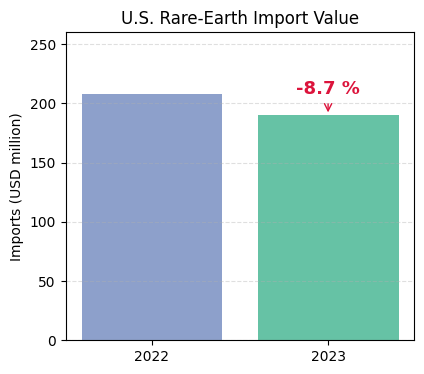

In [107]:
import matplotlib.pyplot as plt

row = df_paragraph.iloc[0]
years = ['2022', '2023']
values = [row['Import_value_2022_mUSD'], row['Import_value_2023_mUSD']]
pct_change = (values[1] - values[0]) / values[0] * 100

fig, ax = plt.subplots(figsize=(4.5, 4))
bars = ax.bar(years, values, color=['#8da0cb', '#66c2a5'])

ax.set_title('U.S. Rare-Earth Import Value')
ax.set_ylabel('Imports (USD million)')

# Annotate % change
color = 'crimson' if pct_change < 0 else 'green'
ax.annotate(f'{pct_change:+.1f} %',
            xy=(1, values[1]),
            xytext=(0, 15),
            textcoords='offset points',
            ha='center', fontsize=13, color=color,
            fontweight='bold',
            arrowprops=dict(arrowstyle='->', color=color))

ax.set_ylim(0, max(values)*1.25)
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [ ]:
# prompt: Using dataframe df_paragraph: print out the full value of other end uses

# Access and print the full value of the 'Other_end_uses' column
print(df_paragraph['Other_end_uses'].iloc[0])

['ceramics and glass', 'metallurgical applications and alloys', 'and polishing']


In [ ]:

lines = text.splitlines()

# 2) Parse Salient Statistics—United States
si = next(i for i, l in enumerate(lines) if 'Salient Statistics' in l)
ei = next(i for i, l in enumerate(lines[si+1:], si+1) if l.startswith('Recycling:'))
salient = []
years = ["2019","2020","2021","2022","2023e"]



In [ ]:
print(lines)

['144', 'RARE EARTHS1', '[Data in metric tons, rare-earth-oxide (REO) equivalent, unless otherwise specified]', 'Domestic Production and Use: Rare earths were mined domestically in 2023. Bastnaesite (or bastnäsite), a rare-', 'earth fluorocarbonate mineral, was mined as a primary product at a mine in Mountain Pass, CA. Monazite, a', 'phosphate mineral, was stockpiled as a separated concentrate or included as an accessory mineral in heavy-mineral-', 'sand concentrates in the southeastern United States. Mixed rare-earth compounds were also produced in the western', 'United States. The estimated value of rare-earth compounds and metals imported by the United States in 2023 was', '$190 million, a 7% decrease from $208 million in 2022. The estimated leading domestic end use of rare earths was', 'catalysts. Significant amounts of rare earths are imported as permanent magnets embedded in finished goods. Other', 'end uses were ceramics and glass, metallurgical applications and alloys, and poli

In [ ]:
print(si)

11


In [ ]:
print(ei)


38


# Salient Stats

In [ ]:
for line in lines[si+1:ei]:
    toks = line.split()
    if len(toks) < 6 or toks[0] in years:
        continue
    cat = " ".join(toks[:-5])
    vals = toks[-5:]
    salient.append([cat] + vals)

df_salient = pd.DataFrame(salient, columns=["Category"]+years)

In [ ]:
df_salient

,Category,2019,2020,2021,2022,2023e
0,Mineral concentrates,"28,000","39,000","e42,000","e42,000","43,000"
1,Compounds and metals,—,—,120,95,250
2,Compounds,"12,200","6,510","7,690","10,700","8,800"
3,"Ferrocerium, alloys",330,270,330,396,300
4,"Rare-earth metals, scandium, and yttrium",627,363,580,487,580
5,Ores and compounds,"28,300","40,000","46,000","46,000","40,000"
6,"Ferrocerium, alloys","1,290",625,825,"1,500",950
7,"Rare-earth metals, scandium, and yttrium",83,25,20,24,64
8,"Consumption, apparent, compounds and metals3","11,800","6,490","e7,900","e10,200","8,800"
9,"Cerium oxide, 99.5% minimum",2,2,2,1,1


In [110]:
import re, pandas as pd

# ------------------------------------------------------------------
# 1.  IMPORT SOURCES (2019-22) -------------------------------------
# ------------------------------------------------------------------
imp_idx = next(i for i,l in enumerate(lines) if l.lower().startswith('import sources'))
imp_line = lines[imp_idx]  # grab the entire sentence

# regex: Country , optional footnote digit,  <number>%
imp_matches = re.findall(r'([A-Za-z]+)[\d\s,]*\s(\d+)%', imp_line)
import_df = pd.DataFrame(imp_matches, columns=['Country', 'Share_%'])
import_df['Share_%'] = import_df['Share_%'].astype(int)

IMPORT SOURCES:
    Country  Share_%
0     China       72
1  Malaysia       11
2     Japan        6

DEPLETION ALLOWANCE:
    Mineral  Domestic_Th%  Domestic_RE%  Foreign_%
0  Monazite            22            14         14


In [119]:
import plotly.express as px

fig = px.treemap(import_df, path=['Country'], values='Share_%',
                 title='U.S. REE Import Share by Country (2019–22)')
fig.show()


In [120]:
import re, pandas as pd

# `lines` already holds every line from the PDF page
tariff_start = next(i for i,l in enumerate(lines) if l.lower().startswith('tariff:'))
tariff_block = []
for l in lines[tariff_start+1:]:
    # stop on first completely blank line or next section title
    if not l.strip() or l.strip().startswith('Depletion'):
        break
    tariff_block.append(l.strip())

# sample tariff_block[0]:
# 'Rare-earth metals 2805.30.0000 5% ad valorem.'


In [125]:
# ─── DROP-IN CELL: Parse Tariff Table from `lines` ─────────────────────────────

import re
import pandas as pd

# 1) Locate the “Tariff:” heading and collect all following non-blank lines
start = next(i for i, l in enumerate(lines) if l.strip().lower().startswith("tariff:"))
tariff_block = []
for l in lines[start+1:]:
    if not l.strip():
        break
    tariff_block.append(l)

# 2) Parse the block into Description, HS_Code, Rate, handling subgroup headers
rows = []
current_group = None
for raw in tariff_block:
    text = raw.strip()
    # detect subgroup header (e.g. “Other rare-earth compounds:”)
    if text.endswith(":") and not re.search(r"\d", text):
        current_group = text.rstrip(":")
        continue
    # match lines like “Desc  <two+spaces>  2805.30.0000  <two+spaces>  5% ad valorem.”
    m = re.match(r'(.+?)\s{2,}([\d.]+)\s{2,}(.+?)\.\s*$', text)
    if not m:
        continue
    desc = m.group(1).strip()
    if current_group:
        desc = f"{current_group} – {desc}"
    rows.append({
        "Description": desc,
        "HS_Code":     m.group(2),
        "Rate":        m.group(3).strip()
    })

# 3) Build DataFrame
df_tariff = pd.DataFrame(rows)



""


In [ ]:


# ------------------------------------------------------------------
# 2.  Locate the heading line (liberal regex to survive variants)
# ------------------------------------------------------------------
heading_pat = re.compile(
    r"world\s+mine\s+production\s+.*reserves", re.I)
wi = next((i for i, l in enumerate(lines) if heading_pat.search(l)), None)
if wi is None:
    raise RuntimeError("World-Mine-Production heading not found; "
                       "inspect 'lines' for exact wording.")

# ------------------------------------------------------------------
# 3.  Find the '2022   2023' header row just below the heading
# ------------------------------------------------------------------
yr_idx = next(i for i in range(wi + 1, len(lines))
              if re.match(r"\s*2022\s+2023\s*", lines[i]))
years = lines[yr_idx].split()  # → ['2022', '2023']

# ------------------------------------------------------------------
# 4.  Pull rows until a blank line or next section
#     Accepts digits, commas, 'NA', em-dash, en-dash, footnote superscripts
# ------------------------------------------------------------------
row_pat = re.compile(
    r"(?P<Country>.+?)\s+"
    r"(?P<y2022>[0-9,–—NA]+)\s+"
    r"(?P<y2023>[0-9,–—NA]+)\s+"
    r"(?P<Reserves>[0-9,–—NA]+)"
)

records = []
for raw in lines[yr_idx + 1:]:
    if not raw.strip():                      # blank → end table
        break
    m = row_pat.match(raw)
    if m:
        rec = m.groupdict()
        records.append(rec)

# ------------------------------------------------------------------
# 5.  Build DataFrame and clean the numbers
# ------------------------------------------------------------------
df_world = pd.DataFrame(records)

def to_int(col):
    # strip commas, em-dashes, en-dashes, footnotes, convert NA/—/– to NaN
    cleaned = (
        col.str.replace(r"[,\u2013\u2014]", "", regex=True)  # commas & dashes
           .str.replace(r"[^\d]", "", regex=True)            # footnotes etc.
           .replace("", pd.NA)
    )
    return pd.to_numeric(cleaned, errors="coerce").astype("Int64")

df_world[f"Mine production {years[0]}"] = to_int(df_world.pop("y2022"))
df_world[f"Mine production {years[1]}"] = to_int(df_world.pop("y2023"))
df_world["Reserves"]                     = to_int(df_world["Reserves"])

# optional: move total row to bottom or drop it
df_world


,Country,Reserves,Mine production 2022,Mine production 2023
0,United States,1800000,42000,43000
1,Australia,105700000,18000,18000
2,Brazil,21000000,80,80
3,Burma,<NA>,12000,38000
4,Canada,830000,<NA>,<NA>
5,China,44000000,11210000,11240000
6,Greenland,1500000,<NA>,<NA>
7,India,6900000,2900,2900
8,Madagascar,<NA>,960,960
9,Malaysia,<NA>,80,80


In [127]:
import plotly.express as px

# 1) Prepare the DataFrame: drop the “World total” row and any missing data
plot_df = (
    df_world
    .query("Country != 'World total (rounded)'")
    .dropna(subset=['Mine production 2023', 'Reserves'])
)

# 2) Make the bubble chart
fig = px.scatter(
    plot_df,
    x='Mine production 2023',
    y='Reserves',
    size='Reserves',              # bubble area ∝ reserves
    hover_name='Country',
    log_x=True, log_y=True,       # log scales for clarity
    size_max=60,                  # max bubble diameter
    labels={
        'Mine production 2023': 'Production 2023 (t REO)',
        'Reserves': 'Reserves (t REO)'
    },
    title='Global Rare-Earth Mine Production vs. Reserves (2023)'
)

fig.update_layout(
    xaxis=dict(tickformat=","),
    yaxis=dict(tickformat=","),
    legend_title_text=''
)
fig.show()


In [ ]:
pattern = re.compile(
    r"Magnets\s+(\d+)%[\s\S]*?Catalysts\s+(\d+)%[\s\S]*?Phosphors\s+(\d+)%"
    r"[\s\S]*?Batteries\s+(\d+)%[\s\S]*?Other\s+(\d+)%", re.I)
magn, catal, phosph, batt, other = map(int, pattern.search(text).groups())
end_pct = dict(Magnets=magn, Catalysts=catal, Phosphors=phosph, Batteries=batt, Other_Uses=other)
enduse_tonnes = {k: world_t * v / 100 for k, v in end_pct.items()}
pd.Series(enduse_tonnes).to_csv('intermediate/enduse_2023_tonnes.csv')
enduse_tonnes


### 3. Build the Sankey diagram